In [191]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [190]:
cd ..


/home/ck/pythonWorkspace


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'pall' : pall,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,        
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        'pall' : pall,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [192]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [193]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

In [194]:
obs_gpmf.head()

,prcp,q925,q650,t925,pall,shear,month,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon
0,33.945941,16.032429,5.258263,21.451288,"[0.10314908445050522, 0.11213220449627026, 0.1...",21.597702,9,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676
1,4.216382,13.945688,6.594621,21.226892,"[0.04182065917067548, 0.012917569451466774, 0....",-3.408928,8,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099
2,59.185143,14.722182,4.939521,24.223535,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.380962,7,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891
3,2.248306,17.130347,6.434912,21.410577,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.177017,8,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657
4,43.297786,16.088208,5.281735,27.334863,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47585907...",20.113298,6,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053


In [195]:
futf['theta_e']

0         5.521202
1         6.515116
2         3.830775
3         4.052897
4         3.749018
           ...    
10228     6.755763
10229     6.637091
10230    16.394919
10231    13.086865
10232    12.657282
Name: theta_e, Length: 99291, dtype: float64

In [196]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [197]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-12,12,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-3.5,2,11,13.5]
nb = 25
region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(5,21,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,75,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(6,20,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,80,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-7.9,6,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-7.9,7.9,nb), np.linspace(20,92,nb)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 5
m2 = 10
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [198]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -11.76275634765625 11.990509033203125
OBS_gpm 9.000161827841007 17.74562661158754 -11.996923725377139 11.996942654145766


In [199]:
len(obs_gpm)

29392

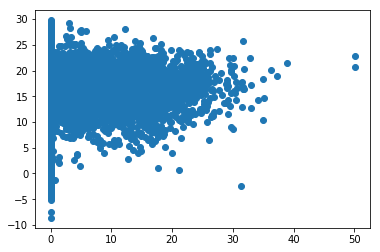

In [200]:
plt.scatter(hist.tgrad, hist.shear)

Text(0.5,1,'-0.56')

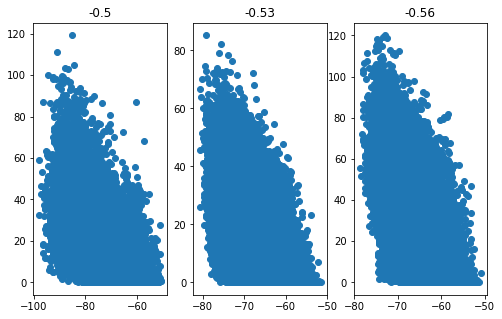

In [201]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5,1,'-0.48')

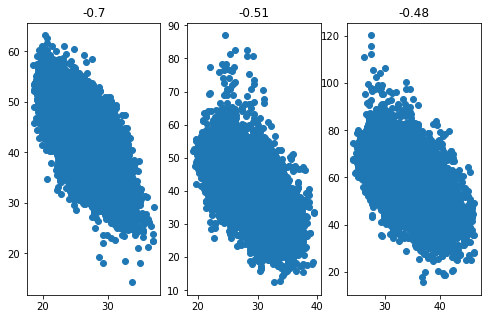

In [202]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [203]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

#     rr = stats.pearsonr(v1,v2)
#     print('pears', stats.pearsonr(v1,v2))
    
    return data

In [226]:
oposi =  (obs_gpm.q925>=8.) & (obs_gpm.prcp>=5) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.shear>0) & (obs_gpm.tmin<=-55)  # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #(obs_gpm.q925>=9.) & (obs_gpm.shear>-5) & 
cposi =   (hist.q925>=8.) &(hist.prcp>=5)  & (hist.theta_e>=-40) & (np.isfinite(hist.q925)) & (hist.shear>0)  & (hist.area>=5000) & (hist.tmin<=-55)  #(hist.q925>=9.) & (hist.shear>-5) &
fposi =  (fut.q925>=8.) &(fut.prcp>=5)  & (fut.theta_e>=-40) & (np.isfinite(fut.q925)) & (fut.shear>0)  & (fut.area>=5000) & (fut.tmin<=-55)   #(fut.q925>=9.) & (fut.shear>-5) & 

In [227]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

In [228]:
cp4.area.min()

5014.240000000001

In [229]:
obs.area.min()

5225

In [230]:
len(obs)

24863

In [231]:
len(cp4)

50154

In [232]:
len(cp4f)

38246

In [233]:
print(np.mean(cp4.shear))

16.342051727871105


In [234]:
print(np.mean(cp4f.shear))

16.744970364234906


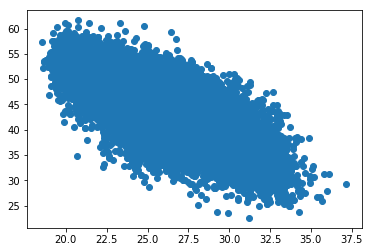

In [235]:
plt.scatter(obs['t925'], obs['tcwv'])

In [236]:
np.min(obs['tcwv'])

22.560836791992188

In [237]:
len(cp4f['tcwv'])

38246

In [238]:
len(cp4['tcwv'])

50154

In [244]:
cp4f['tcwv']-cp4['tcwv']

1148    NaN
1149    NaN
1150    NaN
1151    NaN
1152    NaN
         ..
15107   NaN
15115   NaN
15117   NaN
15127   NaN
15128   NaN
Name: tcwv, Length: 175367, dtype: float64

In [240]:
obs_basic = hist2d.basic_1d_binning(obs['tcwv'], np.arange(np.min(obs['tcwv']), np.max(obs['tcwv']),1))
cp4_basic = hist2d.basic_1d_binning(cp4['tcwv'], np.arange(np.min(cp4['tcwv']), np.max(cp4['tcwv']),1))
cp4f_basic = hist2d.basic_1d_binning(cp4f['tcwv'], np.arange(np.min(cp4f['tcwv']), np.max(cp4f['tcwv']),1))

In [251]:
obs_basic_shear = hist2d.basic_1d_binning(obs['shear'], np.arange(np.min(obs['shear']), np.max(obs['shear']),1))
cp4_basic_shear = hist2d.basic_1d_binning(cp4['shear'], np.arange(np.min(cp4['shear']), np.max(cp4['shear']),1))
cp4f_basic_shear = hist2d.basic_1d_binning(cp4f['shear'], np.arange(np.min(cp4f['shear']), np.max(cp4f['shear']),1))

In [252]:
obs_basic_pr = hist2d.basic_1d_binning(obs['prcp'], np.arange(np.min(obs['prcp']), np.max(obs['prcp']),1))
cp4_basic_pr = hist2d.basic_1d_binning(cp4['prcp'], np.arange(np.min(cp4['prcp']), np.max(cp4['prcp']),1))
cp4f_basic_pr = hist2d.basic_1d_binning(cp4f['prcp'], np.arange(np.min(cp4f['prcp']), np.max(cp4f['prcp']),1))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


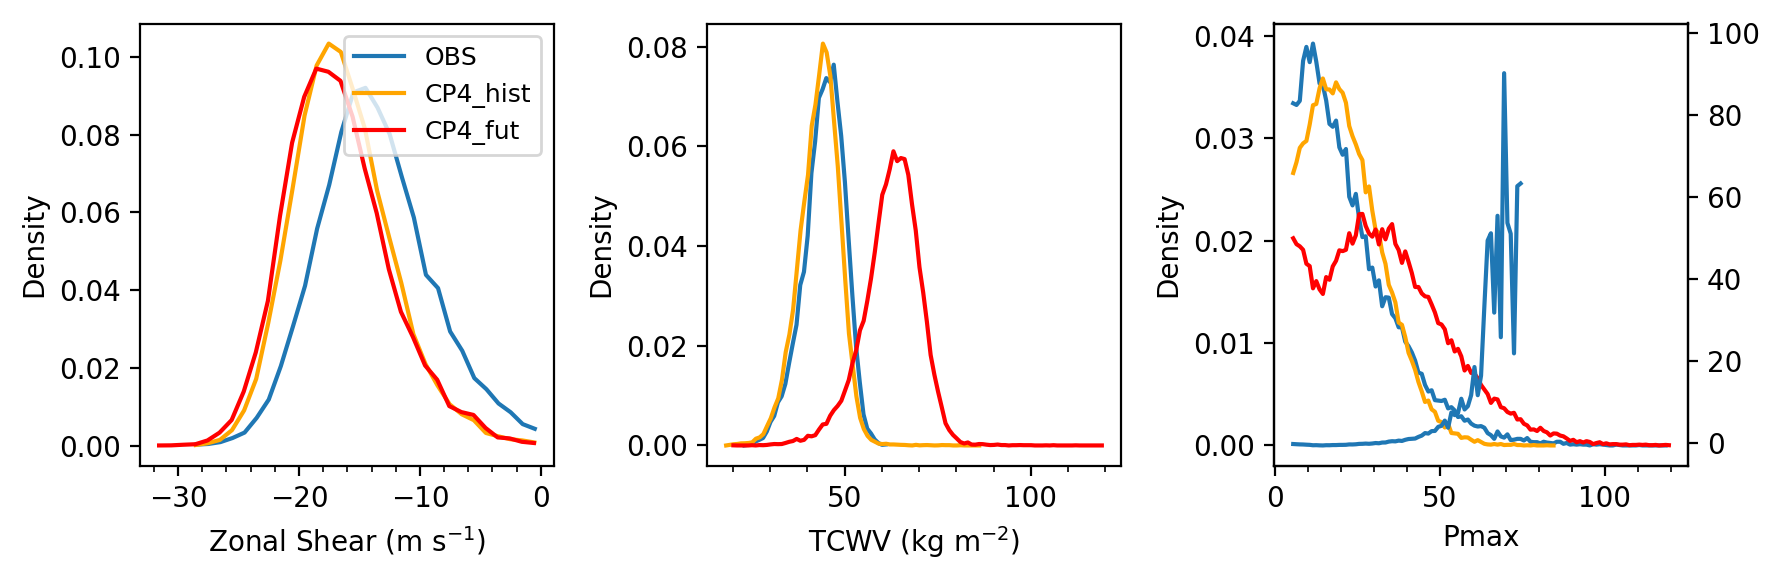

In [260]:
f = plt.figure(figsize=(9,3), dpi=200)
ax = f.add_subplot(131)
plt.plot(obs_basic_shear['xbins']*(-1), obs_basic_shear['nb']/np.sum(obs_basic_shear['nb']), label='OBS')
plt.plot(cp4_basic_shear['xbins']*(-1), cp4_basic_shear['nb']/np.sum(cp4_basic_shear['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic_shear['xbins']*(-1), cp4f_basic_shear['nb']/np.sum(cp4f_basic_shear['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('Zonal Shear (m s$^{-1}$)')
plt.legend(loc='upper right', fontsize=9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')
# for xx in range(5,26,5):
#     plt.axvline(xx, linestyle='dashed', color='slategrey', linewidth=0.5)
ax = f.add_subplot(132)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('TCWV (kg m$^{-2}$)')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

ax = f.add_subplot(133)
plt.plot(obs_basic_pr['xbins'], obs_basic_pr['nb']/np.sum(obs_basic_pr['nb']), label='OBS')
plt.plot(cp4_basic_pr['xbins'], cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic_pr['xbins'], cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('Pmax')
ax1 = ax.twinx()
ax1.plot(cp4_basic_pr['xbins'], (np.array(cp4f_basic_pr['nb']/np.sum(cp4f_basic_pr['nb']))[0:80]-(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))/(cp4_basic_pr['nb']/np.sum(cp4_basic_pr['nb'])))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor')

#plt.xlim(19,80)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/distribution_'+tag+'_OBS_CP4_driver_'+ttag+'_percentile.png')

In [243]:

print('Average shear change ABS', np.percentile(cp4f['shear'],50)-np.percentile(cp4['shear'],50))
print('Average shear change REL', (np.median(cp4f['shear'])-np.median(cp4['shear']))/np.median(cp4['shear']))

Average shear change ABS 0.4599113249023006
Average shear change REL 0.027558122800627


In [245]:
print('Average tcwv change ABS', np.median(cp4f['tcwv'])-np.median(cp4['tcwv']))
print('Average shear change REL', (np.mean(cp4f['tcwv'])-np.mean(cp4['tcwv']))/np.mean(cp4['tcwv']))

Average tcwv change ABS 19.56758927047367
Average shear change REL 0.4483784326870882


In [248]:
print('Average tcwv change ABS', np.array(cp4f['tcwv']).size-np.array(cp4['tcwv']).size)
print('Average shear change REL', (np.array(cp4f['tcwv']).size-np.array(cp4['tcwv']).size)/np.array(cp4['tcwv']).size)

Average tcwv change ABS -11908
Average shear change REL -0.23742871954380507


In [115]:
p = 90
np.percentile(cp4['prcp'][cp4['prcp']>0],p)

35.59963076949903

In [116]:
np.percentile(cp4f['prcp'][cp4f['prcp']>0],p)

56.532221393795666

In [118]:
(np.percentile(cp4f['prcp'][cp4f['prcp']>0],p)-np.percentile(cp4['prcp'][cp4['prcp']>0],p))/np.percentile(cp4['prcp'][cp4['prcp']>0],p)

0.5880002171885225

In [121]:
def read_all(isdata, rainthresh):
    isdata = np.concatenate(np.array(isdata), axis=0)
    isdata = isdata[isdata>rainthresh]
    return isdata

cp4all = np.mean(read_all(cp4['pall'],1))
cp4fall = np.mean(read_all(cp4f['pall'],1))

In [122]:
cp4all

7.16681726929511

In [123]:
cp4fall

9.500036947510191

In [ ]:
f = plt.figure(figsize=(9,3), dpi=200)
ax = f.add_subplot(121)
plt.plot(sheardiff_basic['xbins']*(-1), sheardiff_basic['nb']/np.sum(sheardiff_basic['nb']), label='OBS')
# plt.plot(cp4_basic_shear['xbins']*(-1), cp4_basic_shear['nb']/np.sum(cp4_basic_shear['nb']), color='orange', label='CP4_hist')
# plt.plot(cp4f_basic_shear['xbins']*(-1), cp4f_basic_shear['nb']/np.sum(cp4f_basic_shear['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('Zonal Shear (m s$^{-1}$)')
plt.legend(loc='upper right', fontsize=9)
# for xx in range(5,26,5):
#     plt.axvline(xx, linestyle='dashed', color='slategrey', linewidth=0.5)
ax = f.add_subplot(122)
plt.plot(tcdiff_basic['xbins'], tcdiff_basic['nb']/np.sum(tcdiff_basic['nb']), label='OBS')
#plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='orange', label='CP4_hist')
#plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='red', label='CP4_fut')
plt.ylabel('Density')
plt.xlabel('TCWV (kg m$^{-2}$)')
# for xx in range(20,81,5):
#     plt.axvline(xx, linestyle='dashed', color='slategrey', linewidth=0.5)
#plt.xlim(19,80)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/distribution_'+tag+'_OBS_CP4_driver_'+ttag+'_percentile.png')

In [129]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [130]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_future_50C.png')

In [131]:
vlist = ['prcp', 'area', 'tmin'] # place to change precip input

In [146]:
def get_percentile(x, ttag):
    
    if ttag == 'hourly':
        ptag = [0.05]+list(np.arange(5,96,5))+[99.95]
    else:
        ptag =  [0.5]+list(np.arange(5,96,5))+[99.5]
                         
    return np.percentile(x[np.isfinite(x)], ptag) 

In [147]:
# obs_q925 = hist2d.create_2dhist(obs.shear, obs.q925, get_percentile(obs.shear), get_percentile(obs.q925), obs, vlist)
# obs_theta = hist2d.create_2dhist(obs.shear, obs.theta_e, get_percentile(obs.shear), get_percentile(obs.theta_e), obs, vlist)
# obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, get_percentile(obs.shear), get_percentile(obs.tcwv), obs, vlist)

# cp4_q925 = hist2d.create_2dhist(cp4.shear, cp4.q925, get_percentile(cp4.shear), get_percentile(cp4.q925), cp4, vlist)
# cp4_theta = hist2d.create_2dhist(cp4.shear, cp4.theta_e,get_percentile(cp4.shear), get_percentile(cp4.theta_e), cp4, vlist)
# cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, get_percentile(cp4.shear), get_percentile(cp4.tcwv), cp4, vlist)

# cp4f_q925 = hist2d.create_2dhist(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear), get_percentile(cp4f.q925), cp4f, vlist)
# cp4f_theta = hist2d.create_2dhist(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear), get_percentile(cp4f.theta_e), cp4f, vlist)
# cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear), get_percentile(cp4f.tcwv), cp4f, vlist)

In [148]:
percent=95
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, get_percentile(obs.shear, ttag), get_percentile(obs.q925, ttag), obs, vlist, percentile=percent)
obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, get_percentile(obs.shear, ttag), get_percentile(obs.theta_e, ttag), obs, vlist, percentile=percent)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, get_percentile(obs.shear, ttag), get_percentile(obs.tcwv, ttag), obs, vlist, percentile=percent)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, get_percentile(cp4.shear, ttag), get_percentile(cp4.q925, ttag), cp4, vlist, percentile=percent)
cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e,get_percentile(cp4.shear, ttag), get_percentile(cp4.theta_e, ttag), cp4, vlist, percentile=percent)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, get_percentile(cp4.shear, ttag), get_percentile(cp4.tcwv, ttag), cp4, vlist, percentile=percent)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.q925, ttag), cp4f, vlist, percentile=percent)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.theta_e, ttag), cp4f, vlist, percentile=percent)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, get_percentile(cp4f.shear, ttag), get_percentile(cp4f.tcwv, ttag), cp4f, vlist, percentile=percent)

In [149]:
# percent = 90
# obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, shearbins, qbins, obs, vlist, percent)
# obs_theta = hist2d.create_2dhist_centile(obs.shear, obs.theta_e, shearbins, thetabins, obs, vlist, percent)
# obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percent)

# cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist, percent)
# cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percent)
# cp4_theta = hist2d.create_2dhist_centile(cp4.shear, cp4.theta_e, shearbins, thetabins, cp4, vlist, percent)

# cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist, percent)
# cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist,percent)
# cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist, percent)

In [150]:
cp4f_q925.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [151]:
def plot_dic_tmin(dic, vmin, vmax, xlabel, ylabel, tag):
    
    odic = {
    'data' : dic['tmin'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': minimum temperature',
    'valid' : dic['tmin_val'],
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_prcp(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['prcp'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': maximum precipitation',
    'valid' : dic['prcp_val'],
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }
    return odic
    
def plot_dic_area(dic, vmin, vmax, xlabel, ylabel, tag):
    odic = {
    'data' : dic['area'],
    'ybins' : dic['ybins'],
    'xbins' : dic['xbins'],
    'title' : tag+': MCS area',
    'valid' : dic['area_val'],
    'cbarlabel' : r'km$^{2}$',
    'vmin' : vmin, 
    'vmax' : vmax, 
    'ylabel' : ylabel,
    'xlabel' : xlabel     
    }    
    return odic

In [152]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [153]:
obs_tcwv.keys()

dict_keys(['prcp', 'prcp_val', 'area', 'area_val', 'tmin', 'tmin_val', 'xbins', 'ybins'])

In [154]:
shape = obs_q925['tmin'].shape
shapet = obs_tcwv['tmin'].shape
# shearscat = binning_hist(shearbins[np.newaxis,:],shape)
# qscat = binning_hist(qbins,shape)
# wvscat = binning_hist(tcwvbins,shapet)
# thetascat = binning_hist(thetabins,shape)

In [155]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals = []
    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            vals[vals==0] = np.nan
            tvals = tmin[sh==bins]
            tvals[tvals==0] = np.nan
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<3:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals.append(np.sum(np.isfinite(vals)))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],75))
                    percdown.append(np.percentile(vals[np.isfinite(vals)],25))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
            if np.sum(np.isfinite(tvals))<3:
                tt = np.nan
                ttflag=False
            tmean.append(tt)
            
            if ttflag:
                try:
                    tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                    tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
                except:
                    tpercup.append(np.nan)
                    tpercdown.append(np.nan)
            else:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
                
               
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown, pvals

In [156]:
def run_binning(dic, scat):
    
    binns = np.arange(0,101,5) # collbins
    binns = np.round(binns[0:-1]+((binns[1::]-binns[0:-1])/2),2)
    #ipdb.set_trace()
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)

#     def linregress(bins,data, val):
#         data = np.array(data)
#         pos = np.isfinite(data)
#         val = np.array(val)
#         inbins = bins[pos]
#         indata = data[pos]
#         inval = val[pos]
        
#         slope, intercept, r_value, p_value, std_err = stats.linregress(inbins, indata)
        
#         wlr = sm.OLS(inbins, indata)  #, weights=1./inval
#         p = wlr.fit()
#         print(p.summary())
#         ipdb.set_trace()
#         #p.const + p.motifScore * x
#         return p.motifScore, p.const, 
    
    deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10, pval = binning_2dhist(dic['prcp'], dic['tmin'], scat)
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
    #ipdb.set_trace()
    slope, intercept, r_value, p_value, std_err = linregress(binns, pmean[0:-1], pval[0:-1])
    rslope, rintercept, rr_value, rp_value, rstd_err = linregress(collbins, pmean[0:-1], pval[0:-1])
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pval' : p_value,
        'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'tbox' : tminbox,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'tmean' : tmean[0:-1],
        't90' : t90[0:-1],
        't10' : t10[0:-1],
        'bins' : binns,
        'rbins' : collbins,
        'rslope' : rslope,
        'rintercept' : rintercept,
        'rrval' : rr_value,
        'rpval' : rp_value,
        'rstd_err' : rstd_err
    }
    
    return odic

In [157]:
obs_tcwv_shear = run_binning(obs_tcwv,binning_hist(get_percentile(obs.shear, ttag)[np.newaxis,:],shape))
cp4_tcwv_shear = run_binning(cp4_tcwv,binning_hist(get_percentile(cp4.shear, ttag)[np.newaxis,:],shape))
cp4f_tcwv_shear = run_binning(cp4f_tcwv,binning_hist(get_percentile(cp4f.shear, ttag)[np.newaxis,:],shape))

# obs_tcwv_shear = run_binning(obs_tcwv,get_percentile(obs.shear))
# cp4_tcwv_shear = run_binning(cp4_tcwv,get_percentile(cp4.shear))
# cp4f_tcwv_shear = run_binning(cp4f_tcwv,get_percentile(cp4f.shear))


# obs_shear_q = run_binning(obs_q925,get_percentile(obs.q925))
# cp4_shear_q = run_binning(cp4_q925,get_percentile(cp4.q925))
# cp4f_shear_q = run_binning(cp4f_q925,get_percentile(cp4f.q925))

obs_shear_tcwv = run_binning(obs_tcwv,get_percentile(obs.tcwv, ttag))
cp4_shear_tcwv = run_binning(cp4_tcwv,get_percentile(cp4.tcwv, ttag))
cp4f_shear_tcwv = run_binning(cp4f_tcwv,get_percentile(cp4f.tcwv, ttag))

# obs_shear_theta = run_binning(obs_theta,get_percentile(obs.theta_e))
# cp4_shear_theta = run_binning(cp4_theta,get_percentile(cp4.theta_e))
# cp4f_shear_theta = run_binning(cp4f_theta,get_percentile(cp4f.theta_e))

7.851497867284522
8.983226982003998
14.683757809831356
6.972371212703763
3.4481939249662723
6.83164888279201


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


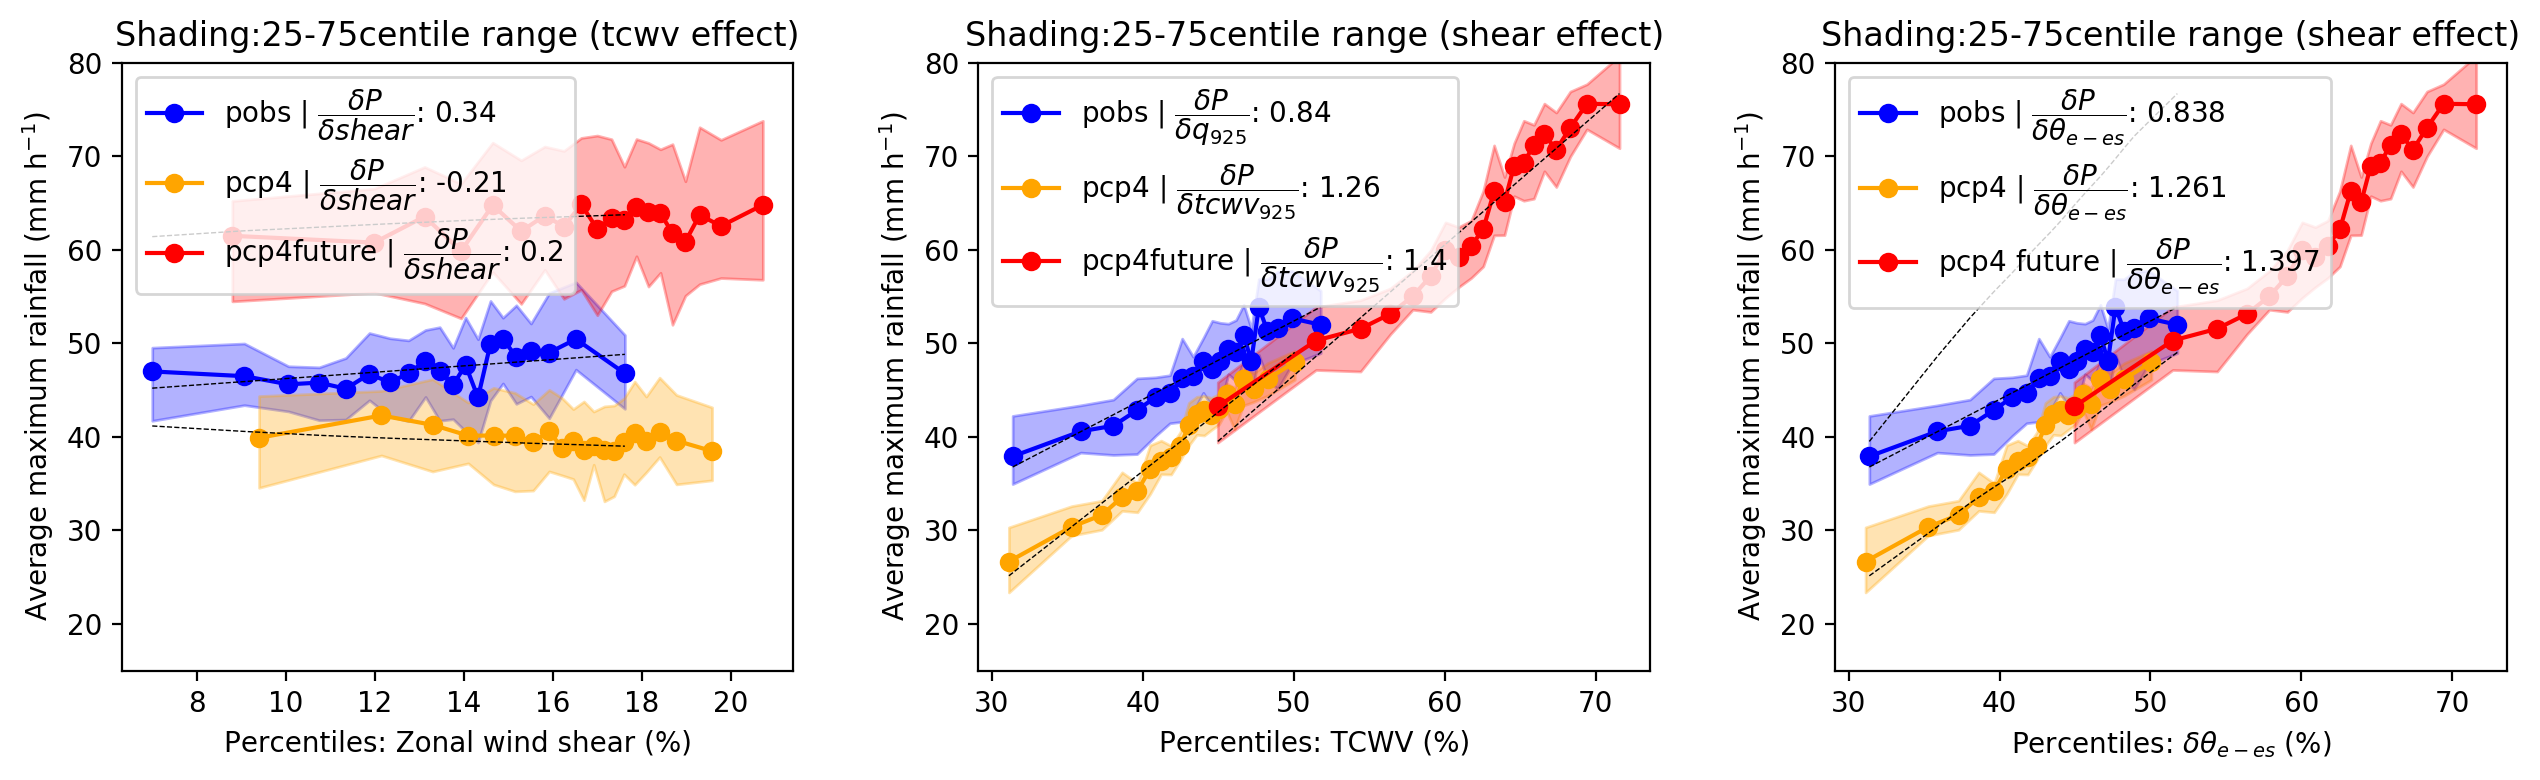

In [158]:
f = plt.figure(figsize=(13,4), dpi=200)

pobs = obs_tcwv_shear
pcp4 = cp4_tcwv_shear
pcp4f = cp4f_tcwv_shear
ax = f.add_subplot(131)
plt.plot(pobs['rbins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['rslope'],2)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['rslope'],2)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label='pcp4future | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4f['rslope'],2)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Percentiles: Zonal wind shear (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (tcwv effect)')
#plt.ylim(10,50)
plt.ylim(15,80)
plt.legend(loc='upper left')

         
# pobs = obs_shear_theta
# pcp4 = cp4_shear_theta
# pcp4f = cp4f_shear_theta
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pobs['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'Percentiles: $\delta \theta _{e-es}$ (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,0)
plt.ylim(15,80)
plt.legend(loc='upper left')

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['rslope'],2)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['rslope'],2)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['rslope'],2)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,80)
plt.ylim(15,80)
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/scatterOrig_'+tag+'_OBS_CP4futureavg_'+ttag+'_perc.png')

Percentage median 3.03


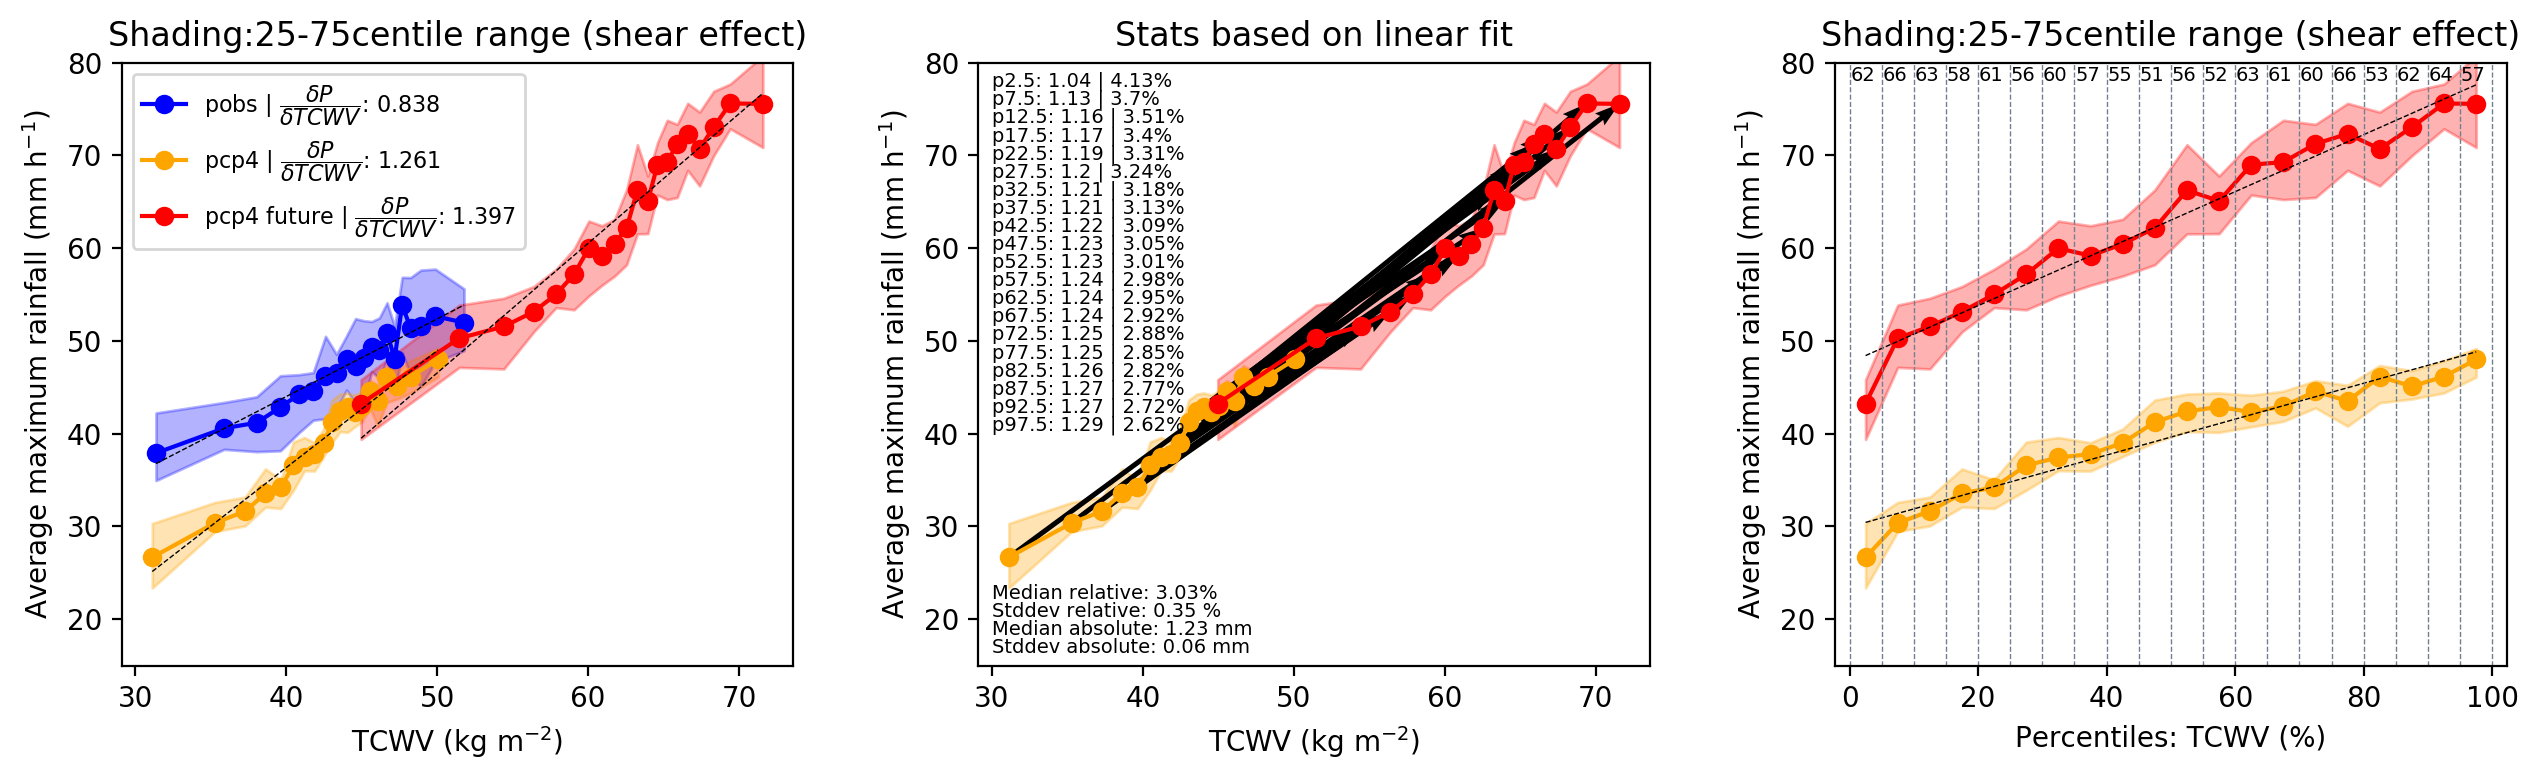

In [159]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

f = plt.figure(figsize=(13,4), dpi=200)

         
pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(131)
plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pobs['rslope'],3)))
plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,0)
plt.ylim(15,80)
plt.legend(loc='upper left', fontsize=8)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'], pcp4['pmean'],(pcp4f['rbins']-pcp4['rbins']),np.array((pcp4f['pmean'])-np.array(pcp4['pmean'])), angles='xy', scale_units='xy', scale=1)

coll = []
abss = []

for ids, percs in enumerate(percents):
    #ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    ppabs = (np.array(((pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'])[ids])-np.array((pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    
    pperc = np.round(ppabs / (pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'])[ids]*100,2)
    plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(pperc)+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

plt.text(0.02, 0.11,'Median relative: '+str(np.round(np.median(coll),2))+'%', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.05,'Median absolute: '+str(np.round(np.median(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Stats based on linear fit')
#plt.ylim(10,0)
plt.ylim(15,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 78,str(ttext), fontsize=7)
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
#plt.ylim(10,80)
plt.ylim(15,80)
#plt.legend(loc='upper left')
plt.ylim(15,80)


plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_linfit_'+ttag+'.png')

In [160]:
yposis = []
yposisf = []
xposis = []
xposisf = []
for rb, rbf in zip(pcp4['rbins'],pcp4f['rbins']):
    yposi = np.nanargmin(np.abs(rb-cp4_basic['xbins']))
    yfposi = np.nanargmin(np.abs(rbf-cp4f_basic['xbins']))
    
    xposi = (cp4_basic['nb']/np.sum(cp4_basic['nb']))[yposi]
    xfposi = (cp4f_basic['nb']/np.sum(cp4f_basic['nb']))[yfposi]
    
#     ipdb.set_trace()

#     pos = np.where(yposis == xposi)
#     if np.sum(np.isfinite(pos)) != 0:
#             xposi = (cp4_basic['nb']/np.sum(cp4_basic['nb']))[yposi+1]

    xposis.append((cp4_basic['xbins'])[yposi])
    xposisf.append((cp4f_basic['xbins'])[yfposi])
    yposis.append(xposi)
    yposisf.append(xfposi)

In [161]:
yposis = np.array(yposis)
yposisf = np.array(yposisf)
xposis = np.array(xposis)
xposisf=np.array(xposisf)

In [162]:
percmid = np.arange(0,101,5)
percents = percmid[0:-1] + (percmid[1::]-percmid[0:-1])/2

In [163]:
pcp4['rbins']

array([31.12, 35.28, 37.28, 38.62, 39.64, 40.48, 41.21, 41.87, 42.48,
       43.04, 43.57, 44.06, 44.54, 45.04, 45.54, 46.07, 46.64, 47.34,
       48.26, 50.06])

In [164]:
pcp4['pmean']

[26.66509091267525,
 30.376347155394278,
 31.638707320046073,
 33.56216082939217,
 34.20953309569826,
 36.58455626222529,
 37.434160592827936,
 37.79353808875737,
 39.0148220624391,
 41.24124274088869,
 42.40677930017522,
 42.88879413011772,
 42.317813889977614,
 42.946589112033976,
 44.56942666624931,
 43.51088476148204,
 46.14536265115002,
 45.10342888793276,
 46.15647433566893,
 47.99864333421434]

Percentage median 3.021977069661694


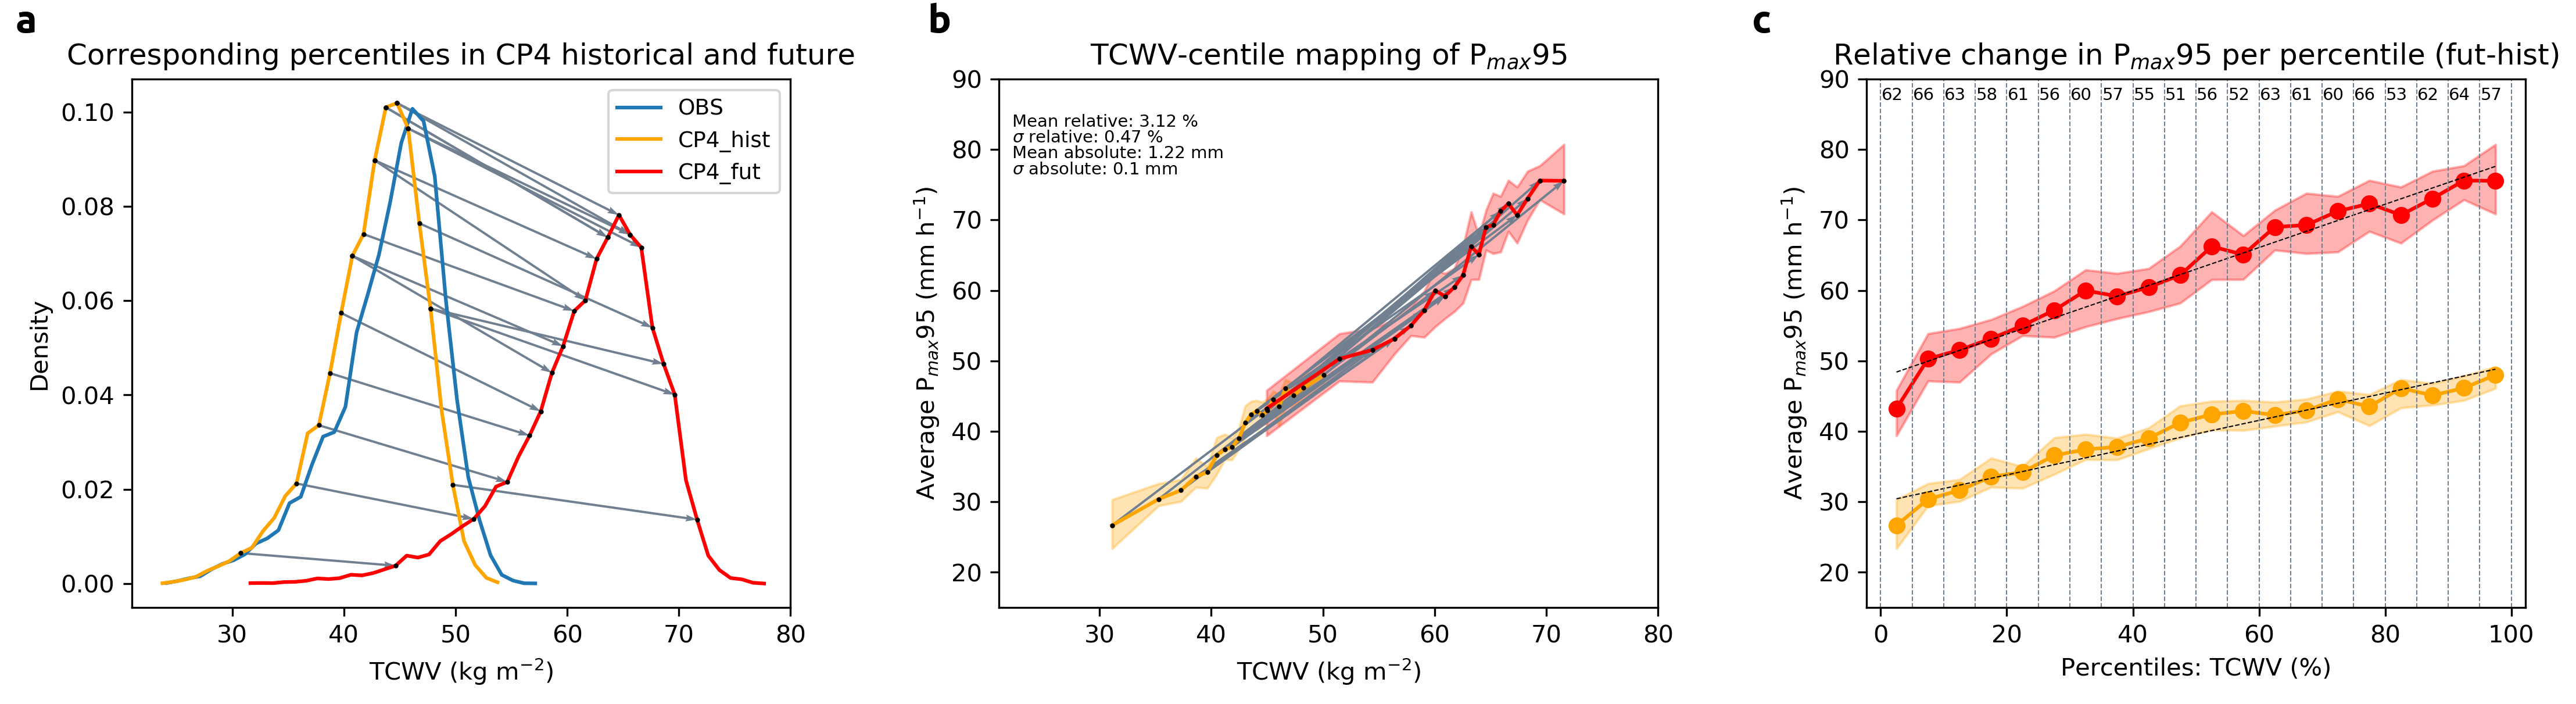

In [165]:


f = plt.figure(figsize=(15,4), dpi=300)

         
ax = f.add_subplot(131)
plt.plot(obs_basic['xbins'], obs_basic['nb']/np.sum(obs_basic['nb']), label='OBS')
plt.plot(cp4_basic['xbins'], cp4_basic['nb']/np.sum(cp4_basic['nb']), color='orange', label='CP4_hist')
plt.plot(cp4f_basic['xbins'], cp4f_basic['nb']/np.sum(cp4f_basic['nb']), color='red', label='CP4_fut')
plt.quiver(xposis, yposis,xposisf-xposis,yposisf-yposis, angles='xy', scale_units='xy', scale=1,  width=0.0035, color='slategrey')
plt.plot(xposis, yposis, marker='o', linestyle='none', markersize=1, color='k')
plt.plot(xposisf, yposisf, marker='o', linestyle='none', markersize=1, color='k')
plt.ylabel('Density')
plt.xlabel('TCWV (kg m$^{-2}$)')
plt.legend(loc='upper right', fontsize=9)
plt.title('Corresponding percentiles in CP4 historical and future')
plt.xlim(21,80)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(132)
#plt.plot(pobs['rbins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['rslope'],3)))
#plt.fill_between(pobs['rbins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['rbins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['rbins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['rbins'],pcp4['pmean'], color='orange', marker='o', markersize=1, label=r'pcp4 | $\dfrac{\delta P}{\delta TCWV}$: ' + str(np.round(pcp4['rslope'],3)))
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='red', marker='o', markersize=1, label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['rslope'],3)))
plt.plot(pcp4['rbins'],pcp4['pmean'], color='k', marker='o', linestyle='none',markersize=1)
plt.plot(pcp4f['rbins'],pcp4f['pmean'], color='k', marker='o', linestyle='none', markersize=1)
#plt.plot(pobs['rbins'],pobs['rslope']*pobs['rbins']+pobs['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4['rbins'],pcp4['rslope']*pcp4['rbins']+pcp4['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(pcp4f['rbins'],pcp4f['rslope']*pcp4f['rbins']+pcp4f['rintercept'], linestyle='dashed', color='k', linewidth=0.5)
#ipdb.set_trace()
plt.quiver(pcp4['rbins'], pcp4['pmean'],(pcp4f['rbins']-pcp4['rbins']),np.array((pcp4f['pmean'])-np.array(pcp4['pmean'])), angles='xy', scale_units='xy', scale=1, color='slategrey', width=0.0035)
plt.xlim(21,80)
coll = []
abss = []

for ids, percs in enumerate(percents):
    ppabs = (np.array((pcp4f['pmean'][ids])-np.array(pcp4['pmean'][ids]))/((pcp4f['rbins'][ids]-pcp4['rbins'][ids])))
    pperc = (ppabs / pcp4['pmean'][ids])*100
    #plt.text(0.02, 0.96-ids*0.03,'p'+str(percs)+': ' + str(np.round(ppabs,2)) + ' | ' + str(np.round(pperc,2))+'%', transform=ax.transAxes, fontsize=7)  #(0.02, 0.08, 'ITD 0-line', color='turquoise', fontsize=12, transform=ax.transAxes)
    coll.append(pperc)
    abss.append(ppabs)

print('Percentage median', np.median(coll))

# plt.text(0.02, 0.11,'Mean relative: '+str(np.round(np.mean(coll),2))+'%', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.08,'Stddev relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.05,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
# plt.text(0.02, 0.02,'Stddev absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)

plt.text(0.02, 0.91,'Mean relative: '+str(np.round(np.mean(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.88,r'$\sigma$ relative: '+str(np.round(np.std(coll),2))+' %', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.85,'Mean absolute: '+str(np.round(np.mean(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
plt.text(0.02, 0.82,'$\sigma$ absolute: '+str(np.round(np.std(abss),2))+' mm', transform=ax.transAxes, fontsize=7)
    
plt.xlabel(r'TCWV (kg m$^{-2}$)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('TCWV-centile mapping of P$_{max}$95')
#plt.ylim(10,0)
plt.ylim(15,90)

pobs = obs_shear_tcwv
pcp4 = cp4_shear_tcwv
pcp4f = cp4f_shear_tcwv
ax = f.add_subplot(133)
#plt.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#plt.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
plt.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
plt.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
plt.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4['slope'],2)))
plt.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta tcwv_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
#plt.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(pcp4f['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
for ids, pp in enumerate(np.arange(0,101,5)):
    plt.axvline(pp, color='slategrey', linestyle='dashed', linewidth=0.5)
    try:
        ttext = np.round((np.array(pcp4f['pmean'])[ids]-np.array(pcp4['pmean'])[ids])/(np.array(pcp4['pmean'])[ids])*100,0).astype(int)
        plt.text(pp+0.1, 87,str(ttext), fontsize=7)
    except:
        pass

plt.xlabel('Percentiles: TCWV (%)')
plt.ylabel('Average P$_{max}$95 (mm h$^{-1}$)')
plt.title('Relative change in P$_{max}$95 per percentile (fut-hist)')
#plt.ylim(10,80)
plt.ylim(15,90)
#plt.legend(loc='upper left')
plt.ylim(15,90)

text = ['a', 'b', 'c']
plt.annotate(text[0], xy=(0.006, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/ENDGAME/scatter_'+tag+'_OBS_CP4futureavg_'+ttag+'_TCWV2_d.png')

In [166]:
tvmin = -83
tvmax = -64

pvmin = 40
pvmax = 55

avmin = 5000
avmax = 90500

thetatmin_dic_obs = plot_dic_tmin(obs_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'OBS')
thetatmin_dic_cp4 = plot_dic_tmin(cp4_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4hist')
thetatmin_dic_cp4f = plot_dic_tmin(cp4f_theta, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4fut')

wvtmin_dic_obs = plot_dic_tmin(obs_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'OBS')
wvtmin_dic_cp4 = plot_dic_tmin(cp4_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4hist')
wvtmin_dic_cp4f = plot_dic_tmin(cp4f_tcwv, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4fut')

qtmin_dic_obs = plot_dic_tmin(obs_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'OBS')
qtmin_dic_cp4 = plot_dic_tmin(cp4_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4hist')
qtmin_dic_cp4f = plot_dic_tmin(cp4f_q925, tvmin, tvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4fut')

thetaprcp_dic_obs = plot_dic_prcp(obs_theta, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'OBS')
thetaprcp_dic_cp4 = plot_dic_prcp(cp4_theta, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4hist')
thetaprcp_dic_cp4f = plot_dic_prcp(cp4f_theta, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'$\Delta \theta _{e-es}$ (K)', 'CP4fut')

wvprcp_dic_obs = plot_dic_prcp(obs_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'OBS')
wvprcp_dic_cp4 = plot_dic_prcp(cp4_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4hist')
wvprcp_dic_cp4f = plot_dic_prcp(cp4f_tcwv, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'TCWV (kg m$^{-2}$)', 'CP4fut')

qprcp_dic_obs = plot_dic_prcp(obs_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'OBS')
qprcp_dic_cp4 = plot_dic_prcp(cp4_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4hist')
qprcp_dic_cp4f = plot_dic_prcp(cp4f_q925, pvmin, pvmax, 'Wind shear (m s$^{-1}$)', r'Low-level humidity (g kg$^{-1}$)', 'CP4fut')

In [ ]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1,2]:
            cmap = 'Blues'
            
        if i in [3,4,5]:
            cmap = 'Blues'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_NOFUTURE_50Cp90.png')

In [247]:
data_list = [qprcp_dic_obs, wvprcp_dic_obs, thetaprcp_dic_obs,qprcp_dic_cp4, wvprcp_dic_cp4, thetaprcp_dic_cp4]

0
1
2
3
4
5


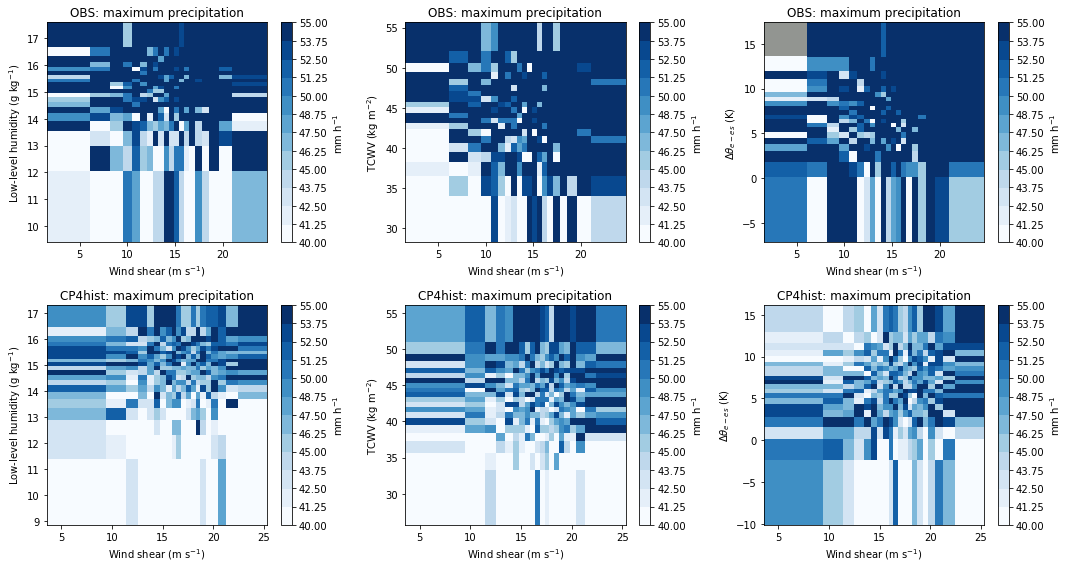

In [458]:
hist2d_six(data_list, valid=True)